# Анализ SQL - запросов к БД StackOverflow

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

### Конфигурация для подключения к базе данных

In [2]:
db_config = {
    'user': '***', # имя пользователя
    'pwd': '***',, # пароль
    'host': '***',,
    'port': ****, # порт подключения
    'db': '***' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения:

In [3]:
engine = create_engine(connection_string) 

# Запрос 1

Вывести общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортировать по убыванию общего количества просмотров.

In [6]:
query_1 = '''
SELECT DISTINCT DATE_TRUNC('month', creation_date) :: date AS month_date,
       SUM(views_count) OVER (PARTITION BY DATE_TRUNC('month', creation_date) :: date) AS total_views
FROM stackoverflow.posts
WHERE DATE_TRUNC('year', creation_date) :: date = '2008-01-01'
ORDER BY total_views DESC
'''

views_df = pd.read_sql_query(query_1, con=engine) 
views_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


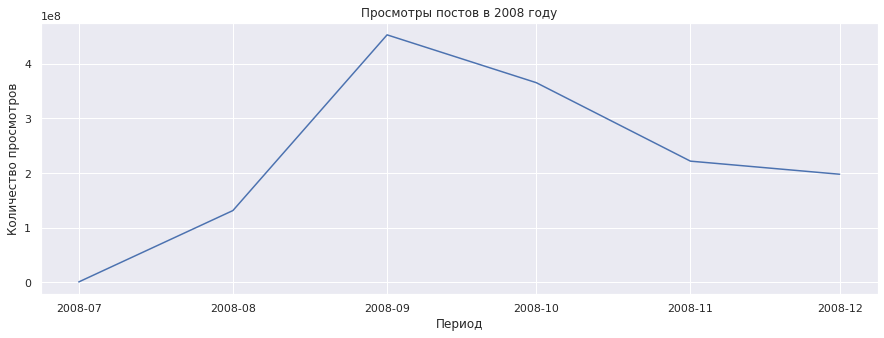

In [7]:
sns.set(rc={'figure.figsize':(15,5)})
sns.lineplot(data = views_df.sort_values('month_date'), x = 'month_date', y = 'total_views')
plt.title('Просмотры постов в 2008 году')
plt.xlabel('Период')
plt.ylabel('Количество просмотров')
plt.show()

Количество просмотров постов в летние месяцы гораздо ниже, чем осенью/зимой. Пик просмотров в 2008г. наблюдался в сентябре. Это можно объяснить учебной/рабочей активностью пользователей. Лето - сезон каникул/отпусков, с осени все возвращаются в рабочий режим, и количество просмотров постов возрастает. К зиме активность пользователей падает.

# Запрос 2

Вывести имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывать. Для каждого имени пользователя вывести количество уникальных значений `user_id`. Отсортировать результат по полю с именами в лексикографическом порядке.

In [8]:
query_2 = '''
WITH active_users as   (SELECT DISTINCT u.display_name,
									  COUNT(p.id) AS count_answers,
									  COUNT(DISTINCT p.user_id) AS count_id
						FROM stackoverflow.users u
						JOIN stackoverflow.posts p ON u.id = p.user_id 
						JOIN stackoverflow.post_types pt ON pt.id = p.post_type_id 
						WHERE pt.type = 'Answer' AND 
							  DATE_TRUNC('day', p.creation_date) <= DATE_TRUNC('day', u.creation_date) + INTERVAL '1 month'
						GROUP BY u.display_name, p.user_id	
						HAVING COUNT(p.id) > 100)
SELECT display_name,
	   count_id
FROM active_users
ORDER BY display_name
'''

active_users_df = pd.read_sql_query(query_2, con=engine) 
active_users_df

,display_name,count_id
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Amy B,1
...,...,...
60,lomaxx,1
61,mattlant,1
62,paxdiablo,1
63,tvanfosson,1


65 пользователей дали более 100 ответов за месяц. У всех активных пользователей есть только одно уникальное значение user_id. Скорее всего, сайт не позволяет создавать пользователей с одинаковыми именами. Среди пользователей встречаются интересные никнеймы, например, 1800 INFORMATION, tzot и др., что показывает, что особых ограничений к имени нет.

# Запрос 3

Вывести количество постов за 2008 год по месяцам. Отобрать посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортировать таблицу по значению месяца по убыванию.

In [9]:
query_3 = '''
SELECT  DISTINCT DATE_TRUNC('month', p.creation_date) :: date AS month_,
        COUNT(p.id) OVER (PARTITION BY DATE_TRUNC('month', p.creation_date) :: date) AS total_posts
FROM stackoverflow.posts p
JOIN stackoverflow.users u ON u.id = p.user_id
WHERE DATE_TRUNC('year', p.creation_date) :: date = '2008-01-01' AND 
      u.id IN  (SELECT DISTINCT u.id
				FROM stackoverflow.users u 
				JOIN stackoverflow.posts p ON u.id = p.user_id
				WHERE DATE_TRUNC('month', u.creation_date) :: date = '2008-09-01' AND
					  DATE_TRUNC('month', p.creation_date) :: date = '2008-12-01')			  
ORDER BY month_ DESC
'''

september_users_df = pd.read_sql_query(query_3, con=engine) 
september_users_df

,month_,total_posts
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


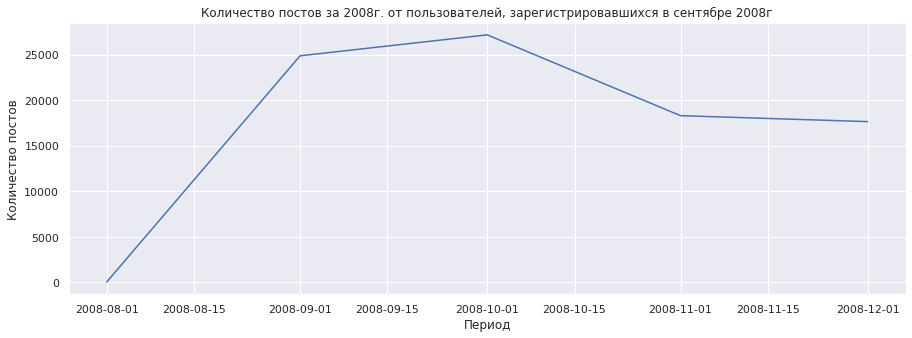

In [10]:
sns.set(rc={'figure.figsize':(15,5)})
sns.lineplot(data = september_users_df.sort_values('month_'), x = 'month_', y = 'total_posts')
plt.title('Количество постов за 2008г. от пользователей, зарегистрировавшихся в сентябре 2008г')
plt.xlabel('Период')
plt.ylabel('Количество постов')
plt.show()

В данных имеется явная аномалия: пользователи зарегистрированы только в сентябре 2008г., а 32 поста от них в базе датируются мартом 2008г. Возможно, произошла техническая ошибка при записи данных.

# Запрос 4

Используя данные о постах, вывести несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице отсортировать по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [11]:
query_4 = '''
SELECT DISTINCT user_id,
			    creation_date,
			    views_count,
			    SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) cumulative_count
FROM stackoverflow.posts p 
ORDER BY user_id, creation_date
'''

cum_count_views_df = pd.read_sql_query(query_4, con=engine) 
cum_count_views_df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Запрос 5

Найти среднее количество постов пользователей в день за август 2008 года. Отобрать данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывать. 

Отсортировать результат по возрастанию среднего количества постов.

In [12]:
query_5 = '''
WITH temp_table AS (SELECT p.user_id,
	   					   p.creation_date :: date,
	   					   COUNT(p.id) AS count_posts
					FROM stackoverflow.posts p
					WHERE date_trunc('month', p.creation_date) :: date = '2008-08-01' AND 
						  p.user_id IN (SELECT u.id
										FROM stackoverflow.posts p
										JOIN stackoverflow.users u ON u.id = p.user_id
										WHERE date_trunc('month', p.creation_date) :: date = '2008-08-01'
										GROUP BY u.id
										HAVING COUNT(p.id) > 120)
GROUP BY p.user_id,
	     p.creation_date :: date) 
SELECT DISTINCT user_id,
	   AVG(count_posts) OVER (PARTITION BY user_id) AS avg_daily
FROM temp_table
ORDER BY avg_daily
'''

avg_dayly_df = pd.read_sql_query(query_5, con=engine) 
avg_dayly_df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Запрос 6

Определить, сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой. Для каждого пользователя отобрать дни, в которые он или она опубликовали хотя бы один пост.

In [13]:
query_6 = '''
WITH temp_table AS (SELECT user_id,
						   COUNT(DISTINCT creation_date :: date) AS count_days
					FROM stackoverflow.posts p 
					WHERE creation_date :: date >= '2008-12-01' AND creation_date :: date <= '2008-12-07'
					GROUP BY user_id)
SELECT ROUND(AVG(count_days))
FROM temp_table
'''

avg_df = pd.read_sql_query(query_6, con=engine) 
avg_df

,round
0,2.0


В первую неделю декабря 2008г. пользователи взаимодействовали с платформой, а именно публиковали посты, в среднем, 2 дня. 

# Запрос 7

Вывести историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортировать вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавить в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, указать `NULL`.

In [14]:
query_7 = '''
SELECT user_id,
	   creation_date,
	   LAG(name_of_month, 2, NULL) OVER (PARTITION BY user_id ORDER BY creation_date)
FROM 
        (SELECT user_id,
               creation_date,
               TO_CHAR(creation_date, 'Month') AS name_of_month
        FROM stackoverflow.posts 
        ORDER BY user_id,
                 creation_date) temp_table
'''

active_story_df = pd.read_sql_query(query_7, con=engine) 
active_story_df.head(10)

,user_id,creation_date,lag
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
5,1,2008-08-04 08:04:42,August
6,1,2008-08-10 08:28:52,August
7,1,2008-08-11 19:23:47,August
8,1,2008-08-12 00:30:43,August
9,1,2008-08-12 04:59:35,August


# Запрос 8

Рассчитать аналог Retention Rate по месяцам для пользователей StackOverflow. Объединить пользователей в когорты по месяцу их первого поста. Возвращение определить по наличию поста в текущем месяце. 

In [15]:
query_8 = '''
WITH first_ts_table AS (SELECT  DISTINCT user_id,
										 MIN(DATE_TRUNC('month', creation_date) :: date) OVER (PARTITION BY user_id) AS first_ts
						FROM stackoverflow.posts),
	 profile AS (SELECT 	user_id,
							first_ts,
							COUNT(user_id) OVER (PARTITION BY first_ts) AS cohort_size
				 FROM first_ts_table),
	 sessions AS (SELECT user_id,
		       			 DATE_TRUNC('month', creation_date) :: date AS session_date
				  FROM stackoverflow.posts
				  GROUP BY 1,
					       2)
SELECT p.first_ts AS cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_size,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_size, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4
'''

retention_rate_df = pd.read_sql_query(query_8, con=engine) 
retention_rate_df

,cohort_dt,session_date,users_cnt,cohort_size,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


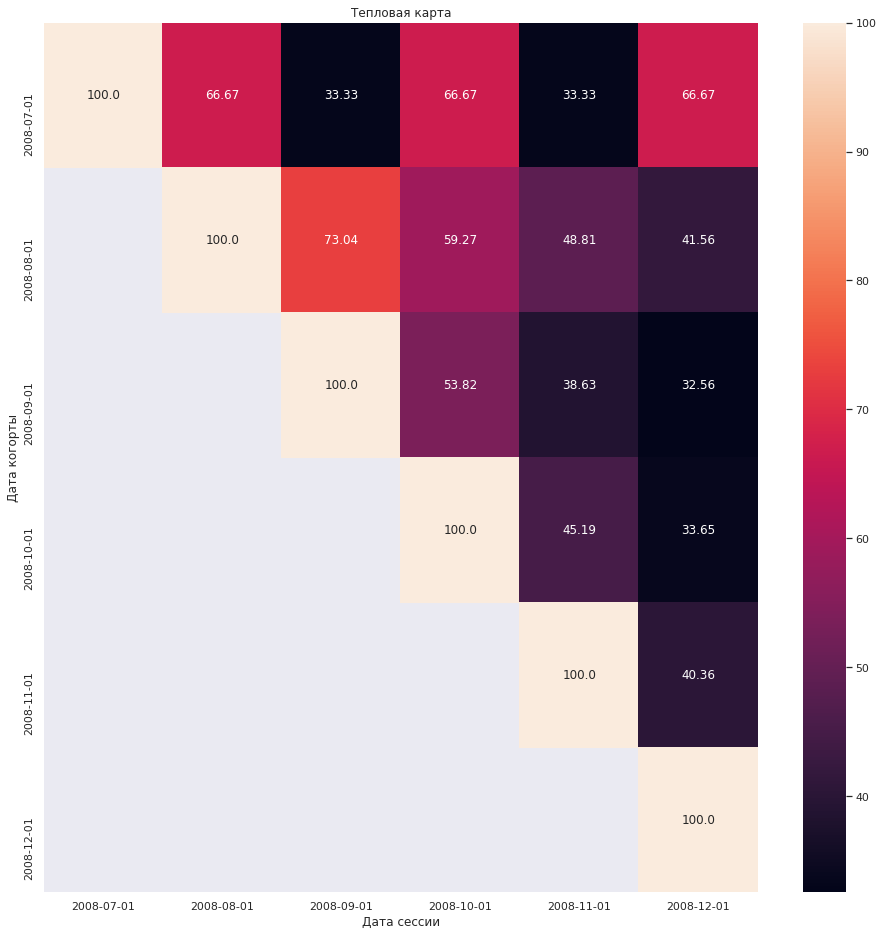

In [16]:
# создаём сводную таблицу с результатами
retention = retention_rate_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

plt.figure(figsize=(16, 16))
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта')
plt.xlabel('Дата сессии')
plt.ylabel('Дата когорты')
plt.show() 

В когорте от июля  2008г. показатель удержания пользователей скачет вверх-вниз. Это связано с тем, что в когорте всего 3 пользователя - выборка не показательна (какой-то пользователь периодически возвращается к написанию постов, что вполне нормально). Высокое удержание первого дня (> 70%) показала августовская когорта, в сентябрьской когорте тоже неплохой показатель в 1-ый день (> 50%). Самое низкое значение удержания первого дня в ноябрьской когорте (40%). 

# Запрос 9


Определить, на сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года. Отобразить таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Округлить значение процента до двух знаков после запятой.

In [17]:
query_9 = '''
WITH temp_table AS (SELECT DISTINCT EXTRACT (MONTH FROM creation_date :: date) AS creation_month,
							COUNT(id) AS posts_count
					FROM stackoverflow.posts p 
					WHERE creation_date :: date >= '2008-09-01' AND 
						  creation_date :: date <= '2008-12-31' 
					GROUP BY EXTRACT (MONTH FROM creation_date :: date))
SELECT  creation_month :: int4,
		posts_count,
		ROUND(((posts_count::numeric / LAG(posts_count) OVER (ORDER BY creation_month)) - 1) * 100, 2) AS percentage
FROM temp_table	
'''

percentage_df = pd.read_sql_query(query_9, con=engine) 
percentage_df

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Круговая диаграмма с количеством постов по месяцам:

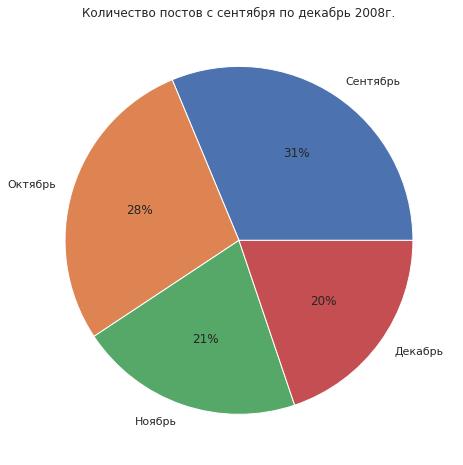

In [18]:
plt.figure(figsize = (8, 8))
plt.pie(percentage_df['posts_count'], 
        labels=['Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'],
        autopct='%.0f%%')
plt.title('Количество постов с сентября по декабрь 2008г.')
plt.show()

Больше всего постов было создано в сентябре - более 70 тыс., в октябре количество постов снизилось до 63 тыс. (-10%). В ноябре активность пользователей резко снизилась до 47 тыс. (-25%), в декабре до 44,5 тыс. (-5%).

# Запрос 10

Выгрузить данные активности пользователя, который опубликовал больше всего постов за всё время. Вывести данные за октябрь 2008 года в следующем виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [19]:
query_10 = '''
WITH table_count_posts AS (SELECT DISTINCT p.user_id,
	   							  COUNT(p.id) AS count_posts
						   FROM stackoverflow.posts p
						   GROUP BY p.user_id),
	 table_user_id AS (SELECT user_id
					   FROM table_count_posts
					   WHERE count_posts = (SELECT max(count_posts)
			   							   FROM table_count_posts)),
	 table_week  AS  (SELECT creation_date,
						     EXTRACT(WEEK FROM creation_date) AS week_number
					  FROM stackoverflow.posts p
					  WHERE user_id = (SELECT user_id
									  FROM table_count_posts
									  WHERE count_posts = (SELECT max(count_posts)
							   							   FROM table_count_posts)) AND 
							   			    DATE_TRUNC('month', creation_date) :: date = '2008-10-01')
SELECT DISTINCT week_number :: int4,
	   LAST_VALUE(creation_date) OVER (PARTITION BY week_number ORDER BY creation_date ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
FROM table_week
ORDER BY week_number
'''

active_user_df = pd.read_sql_query(query_10, con=engine) 
active_user_df

,week_number,last_value
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
